# Drug Composition to Medical Indication Prediction
## Part 1: Data Preprocessing and EDA

This notebook covers:
1. Library installation
2. Data loading and exploration
3. Text preprocessing
4. Medical NER for indication extraction
5. Multi-label encoding preparation

## 1. Install Required Libraries

In [2]:
# Core libraries
!pip install pandas numpy matplotlib seaborn

# NLP libraries
!pip install transformers datasets torch
!pip install sentence-transformers
!pip install scikit-learn

# Medical NLP
!pip install scispacy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_md-0.5.1.tar.gz

# Visualization
!pip install wordcloud plotly

  Using cached spacy-3.8.9-cp310-cp310-macosx_11_0_arm64.whl.metadata (27 kB)
  Using cached thinc-8.3.9-cp310-cp310-macosx_11_0_arm64.whl.metadata (15 kB)
  Using cached blis-1.3.2-cp310-cp310-macosx_11_0_arm64.whl.metadata (7.5 kB)
  Using cached pydantic-2.12.4-py3-none-any.whl.metadata (89 kB)
Using cached spacy-3.8.9-cp310-cp310-macosx_11_0_arm64.whl (6.2 MB)
Using cached thinc-8.3.9-cp310-cp310-macosx_11_0_arm64.whl (772 kB)
Using cached pydantic-2.12.4-py3-none-any.whl (463 kB)
Using cached blis-1.3.2-cp310-cp310-macosx_11_0_arm64.whl (1.2 MB)
  Attempting uninstall: blis
    Found existing installation: blis 0.7.11
    Uninstalling blis-0.7.11:
      Successfully uninstalled blis-0.7.11
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.10.24
    Uninstalling pydantic-1.10.24:
      Successfully uninstalled pydantic-1.10.24
  Attempting uninstall: thinc
    Found existing installation: thinc 8.1.12
    Uninstalling thinc-8.1.12:
      Successfully unin

## 2. Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# NLP libraries
from transformers import pipeline, AutoTokenizer
import spacy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
plt.style.use('seaborn-v0_8-darkgrid')

print("Libraries imported successfully!")

Libraries imported successfully!


## 3. Load Dataset

In [4]:
# Load DrugBank dataset
df = pd.read_csv('drugbank_simplified.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (17430, 13)

Columns: ['type', 'name', 'drugbank-id', 'description', 'indication', 'pharmacodynamics', 'mechanism-of-action', 'toxicity', 'absorption', 'half-life', 'metabolism', 'state', 'cas-number']

First few rows:


,type,name,drugbank-id,description,indication,pharmacodynamics,mechanism-of-action,toxicity,absorption,half-life,metabolism,state,cas-number
0,NaN,Lepirudin,BIOD00024,Lepirudin is a recombinant hirudin formed by 65 amino acids that acts as a highly specific and d...,Lepirudin is indicated for anticoagulation in adult patients with acute coronary syndromes (ACS)...,Lepirudin is a recombinant hirudin that acts as a highly specific thrombin inhibitor. Its activi...,Lepirudin is a direct thrombin inhibitor used as an anticoagulant in patients for whom heparin i...,"The acute toxicity of intravenous lepirudin was evaluated in mice (0.1-1000 mg/kg), rats (1-1000...",Lepirudin administered as a single intravenous bolus injection of 0.4 mg/kg in 9 healthy volunte...,"Lepirudin has an initial half-life of approximately 10 minutes, and in young healthy volunteers,...","As a polypeptide, lepirudin is expected to be metabolized by the sequential cleavage of amino ac...",solid,138068-37-8
1,NaN,Cetuximab,BIOD00071,Cetuximab is a recombinant chimeric human/mouse IgG1 monoclonal antibody that competitively bind...,Cetuximab indicated for the treatment of locally or regionally advanced squamous cell carcinoma ...,Cetuximab is an anticancer agent that works by inhibiting the growth and survival of epidermal g...,The epidermal growth factor receptor (EGFR) is a transmembrane glycoprotein and a type I recepto...,The intravenous LD<sub>50</sub> is > 300 mg/kg in mice and > 200 mg/kg in rats.[L31408] There is...,After administration of a 400 mg/m<sup>2</sup> initial dose followed by a 250 mg/m<sup>2</sup> w...,After administration of a 400 mg/m<sup>2</sup> initial dose followed by a 250 mg/m<sup>2</sup> w...,"Like other monoclonal antibodies, cetuximab is expected to undergo lysosomal degradation by the ...",liquid,205923-56-4
2,NaN,Dornase alfa,BIOD00001,Dornase alfa is a biosynthetic form of human deoxyribunuclease I (DNase I) enzyme. It is produce...,Used as adjunct therapy in the treatment of cystic fibrosis.,Cystic fibrosis (CF) is a disease characterized by the retention of viscous purulent secretions ...,Dornase alfa is a biosynthetic form of human DNase I. The enzyme is involved in endonucleolytic ...,Adverse reactions occur at a frequency of < 1/1000 and are usually mild and transient in nature....,Studies in rats and monkeys after inhalation of dornase alfa shows very little systemic absorpti...,NaN,"While no conclusive studies have yet been published, dornase alfa is expected to be metabolized ...",liquid,143831-71-4
3,NaN,Denileukin diftitox,BIOD00084,"Denileukin diftitox is an IL2-receptor-directed cytotoxin, is a recombinant DNA-derived fusion p...",Denileukin diftitox was previously indicated for the treatment of adult patients with persistent...,Denileukin diftitox is an anticancer drug with cytocidal actions on cancer cells.[L51254] Denile...,"Denileukin diftitox is a fusion protein composed of truncated diphtheria toxin (DT), which is a ...",There is limited information regarding the acute toxicity (LD<sub>50</sub>) and overdose of deni...,Following a single dose of denileukin diftitox 9 mcg/kg via one-hour infusion in patients with C...,The arithmetic mean (CV%) denileukin diftitox terminal half-life is 112 minutes (31%) on the fir...,Denileukin diftitox is expected to be metabolized into small peptides by catabolic pathways.[L51...,liquid,173146-27-5
4,NaN,Etanercept,BIOD00052,Dimeric fusion protein consisting of the extracellular ligand-binding portion of the human 75 ki...,Etanercept is indicated for the treatment of moderately to severely active rheumatoid arthritis ...,Etanercept binds specifically to tumor necrosis factor (TNF) and thereby modulates biological pr...,"There are two distinct receptors for TNF (TNFRs), a 55 kilodalton protein (p55) and a 75 kilodal...",NaN,"Population pharmacokinetic modeling in adults with RA, AS, or who were healthy showed a subcutan...",Etanercept has a mean half-life of elimination of 102

## 4. Exploratory Data Analysis

In [5]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())
print(f"\nMissing percentage:")
print((df.isnull().sum() / len(df) * 100).round(2))

Missing Values:
type                   17430
name                       0
drugbank-id                0
description             7405
indication             13037
pharmacodynamics       14263
mechanism-of-action    13307
toxicity               14882
absorption             14910
half-life              14961
metabolism             15018
state                   8050
cas-number              6663
dtype: int64

Missing percentage:
type                   100.00
name                     0.00
drugbank-id              0.00
description             42.48
indication              74.80
pharmacodynamics        81.83
mechanism-of-action     76.35
toxicity                85.38
absorption              85.54
half-life               85.83
metabolism              86.16
state                   46.18
cas-number              38.23
dtype: float64


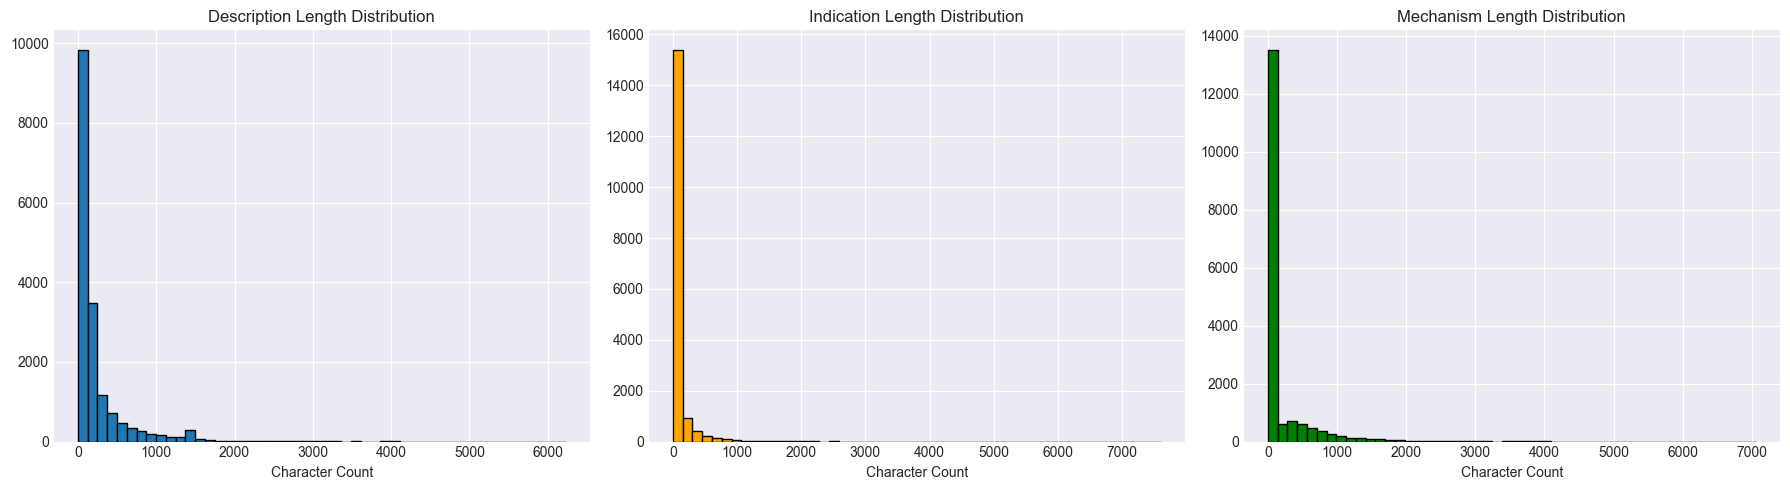


Text Length Statistics:
       description_length  indication_length  mechanism_length
count        17430.000000       17430.000000      17430.000000
mean           218.922433          64.802926        172.796041
std            397.608447         202.805095        436.131760
min              0.000000           0.000000          0.000000
25%              0.000000           0.000000          0.000000
50%             90.000000           0.000000          0.000000
75%            231.000000          29.000000          0.000000
max           6229.000000        7604.000000       7055.000000


In [6]:
# Analyze text length distributions
df['description_length'] = df['description'].fillna('').str.len()
df['indication_length'] = df['indication'].fillna('').str.len()
df['mechanism_length'] = df['mechanism-of-action'].fillna('').str.len()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(df['description_length'], bins=50, edgecolor='black')
axes[0].set_title('Description Length Distribution')
axes[0].set_xlabel('Character Count')

axes[1].hist(df['indication_length'], bins=50, edgecolor='black', color='orange')
axes[1].set_title('Indication Length Distribution')
axes[1].set_xlabel('Character Count')

axes[2].hist(df['mechanism_length'], bins=50, edgecolor='black', color='green')
axes[2].set_title('Mechanism Length Distribution')
axes[2].set_xlabel('Character Count')

plt.tight_layout()
plt.show()

print(f"\nText Length Statistics:")
print(df[['description_length', 'indication_length', 'mechanism_length']].describe())

## 5. Text Preprocessing Functions

In [7]:
def clean_text(text):
    """Clean medical text"""
    if pd.isna(text):
        return ""
    
    # Remove references like [L41539] or [A246609]
    text = re.sub(r'\[.*?\]', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text.strip()

# Apply cleaning
print("Cleaning text fields...")
df['description_clean'] = df['description'].apply(clean_text)
df['indication_clean'] = df['indication'].apply(clean_text)
df['mechanism_clean'] = df['mechanism-of-action'].apply(clean_text)
df['pharmacodynamics_clean'] = df['pharmacodynamics'].apply(clean_text)

print("Text cleaning complete!")

# Example
print("\nExample - Original vs Cleaned:")
print("Original:", df['indication'].iloc[0][:200])
print("\nCleaned:", df['indication_clean'].iloc[0][:200])

Cleaning text fields...
Text cleaning complete!

Example - Original vs Cleaned:
Original: Lepirudin is indicated for anticoagulation in adult patients with acute coronary syndromes (ACS) such as unstable angina and acute myocardial infarction without ST elevation. In patients with ACS, lep

Cleaned: Lepirudin is indicated for anticoagulation in adult patients with acute coronary syndromes (ACS) such as unstable angina and acute myocardial infarction without ST elevation. In patients with ACS, lep


## 6. Create Combined Input Features

In [8]:
# Combine relevant fields for input
def combine_features(row):
    """Combine description, mechanism, and pharmacodynamics"""
    parts = []
    
    if row['description_clean']:
        parts.append(f"Description: {row['description_clean']}")
    
    if row['mechanism_clean']:
        parts.append(f"Mechanism: {row['mechanism_clean']}")
    
    if row['pharmacodynamics_clean']:
        parts.append(f"Pharmacodynamics: {row['pharmacodynamics_clean']}")
    
    return " [SEP] ".join(parts)

df['input_text'] = df.apply(combine_features, axis=1)

print("Combined input features created!")
print(f"\nExample combined text (first 500 chars):\n{df['input_text'].iloc[0][:500]}")

Combined input features created!

Example combined text (first 500 chars):
Description: Lepirudin is a recombinant hirudin formed by 65 amino acids that acts as a highly specific and direct thrombin inhibitor. Natural hirudin is an endogenous anticoagulant found in _Hirudo medicinalis_ leeches. Lepirudin is produced in yeast cells and is identical to natural hirudin except for the absence of sulfate on the tyrosine residue at position 63 and the substitution of leucine for isoleucine at position 1 (N-terminal end). Lepirudin is used as an anticoagulant in patients with


## 7. Extract Medical Conditions from Indication (Multi-Label Target)

In [9]:
# Load Medical NER model
print("Loading Medical NER model...")
ner_model = pipeline(
    "ner", 
    model="d4data/biomedical-ner-all",
    aggregation_strategy="simple"
)
print("NER model loaded!")

Loading Medical NER model...


model.safetensors:   0%|          | 0.00/266M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use mps:0


NER model loaded!


In [10]:
def extract_medical_conditions(text, max_length=512):
    """Extract disease/condition entities using NER"""
    if pd.isna(text) or len(text) == 0:
        return []
    
    try:
        # Truncate to max length
        text = text[:max_length]
        
        # Run NER
        entities = ner_model(text)
        
        # Extract disease/condition entities
        conditions = []
        for entity in entities:
            # Filter for disease-related entities
            if any(disease_type in entity.get('entity_group', '') 
                   for disease_type in ['Disease', 'Disorder', 'Condition']):
                
                condition = entity['word'].lower().strip()
                
                # Filter out very short tokens
                if len(condition) > 3:
                    conditions.append(condition)
        
        return list(set(conditions))
    
    except Exception as e:
        print(f"Error processing text: {e}")
        return []

# Test on a sample
sample_text = df['indication_clean'].iloc[0]
sample_conditions = extract_medical_conditions(sample_text)
print(f"Sample text: {sample_text[:200]}...")
print(f"\nExtracted conditions: {sample_conditions}")

Sample text: Lepirudin is indicated for anticoagulation in adult patients with acute coronary syndromes (ACS) such as unstable angina and acute myocardial infarction without ST elevation. In patients with ACS, lep...

Extracted conditions: ['##embolic disease', '##top', '##rombo', 'coronary syndromes', 'acute', '##ocardial infarction']


In [11]:
# Extract conditions for all indications (this may take a while)
print("Extracting medical conditions from all indications...")
print("This may take 10-20 minutes depending on your machine.\n")

from tqdm.auto import tqdm
tqdm.pandas()

df['conditions'] = df['indication_clean'].progress_apply(extract_medical_conditions)

print("\nCondition extraction complete!")

Extracting medical conditions from all indications...
This may take 10-20 minutes depending on your machine.



  0%|          | 0/17430 [00:00<?, ?it/s]


Condition extraction complete!


In [12]:
# Analyze extracted conditions
all_conditions = [cond for cond_list in df['conditions'] for cond in cond_list]
condition_counts = Counter(all_conditions)

print(f"Total conditions extracted: {len(all_conditions)}")
print(f"Unique conditions: {len(set(all_conditions))}")
print(f"\nTop 20 most common conditions:")
for condition, count in condition_counts.most_common(20):
    print(f"{condition:40s}: {count:4d}")

Total conditions extracted: 5339
Unique conditions: 2274

Top 20 most common conditions:
infections                              :  161
infection                               :   58
diabetes mellitus                       :   49
leukemia                                :   49
cancer                                  :   40
schizophrenia                           :   36
##oma                                   :   34
tumors                                  :   30
pneumonia                               :   29
bacterial                               :   28
heart failure                           :   27
inflammatory disorders                  :   27
lung cancer                             :   26
hyper                                   :   23
multiple                                :   23
##yp                                    :   22
##te                                    :   20
asthma                                  :   20
chronic obstructive pulmonary disease   :   20
##ym              

## 8. Filter Frequent Conditions

In [13]:
# Keep only conditions that appear at least MIN_FREQ times
MIN_FREQ = 5

frequent_conditions = [cond for cond, count in condition_counts.items() if count >= MIN_FREQ]

print(f"Conditions with at least {MIN_FREQ} occurrences: {len(frequent_conditions)}")

# Filter conditions
df['conditions_filtered'] = df['conditions'].apply(
    lambda x: [c for c in x if c in frequent_conditions]
)

# Remove rows with no conditions
df_filtered = df[df['conditions_filtered'].str.len() > 0].copy()

print(f"\nDataset size after filtering: {len(df_filtered)} drugs")
print(f"Average conditions per drug: {df_filtered['conditions_filtered'].str.len().mean():.2f}")

Conditions with at least 5 occurrences: 231

Dataset size after filtering: 1630 drugs
Average conditions per drug: 1.54


## 9. Create Multi-Label Encoding

In [14]:
# Multi-label binarizer
mlb = MultiLabelBinarizer()
y_multilabel = mlb.fit_transform(df_filtered['conditions_filtered'])

print(f"Multi-label shape: {y_multilabel.shape}")
print(f"Number of classes: {len(mlb.classes_)}")
print(f"\nClass distribution (top 20):")

class_counts = y_multilabel.sum(axis=0)
top_classes = np.argsort(class_counts)[::-1][:20]

for idx in top_classes:
    print(f"{mlb.classes_[idx]:40s}: {class_counts[idx]:4d}")

Multi-label shape: (1630, 231)
Number of classes: 231

Class distribution (top 20):
infections                              :  161
infection                               :   58
diabetes mellitus                       :   49
leukemia                                :   49
cancer                                  :   40
schizophrenia                           :   36
##oma                                   :   34
tumors                                  :   30
pneumonia                               :   29
bacterial                               :   28
heart failure                           :   27
inflammatory disorders                  :   27
lung cancer                             :   26
hyper                                   :   23
multiple                                :   23
##yp                                    :   22
##te                                    :   20
asthma                                  :   20
chronic obstructive pulmonary disease   :   20
##ym                   

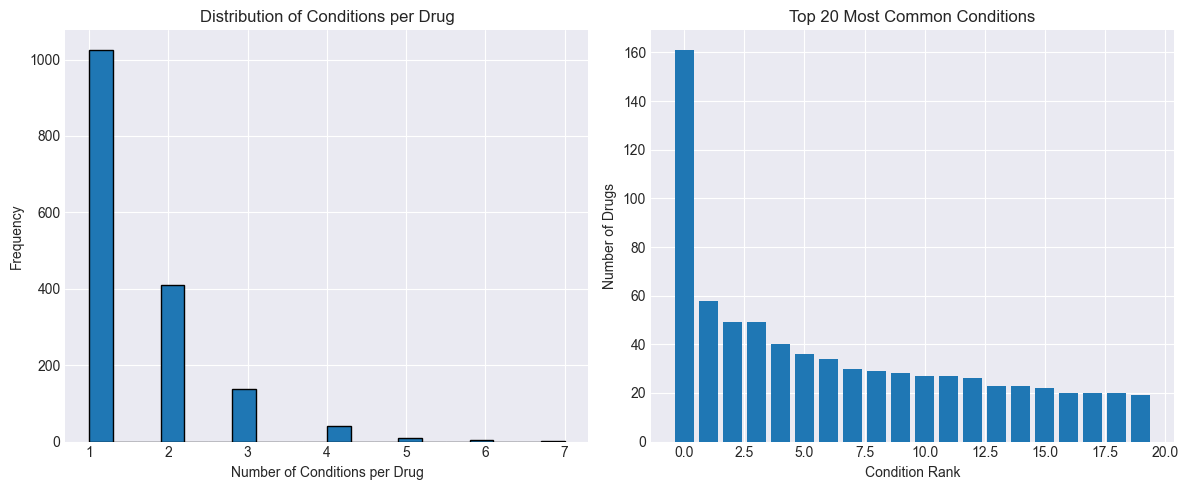

In [15]:
# Visualize label distribution
labels_per_sample = y_multilabel.sum(axis=1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(labels_per_sample, bins=20, edgecolor='black')
plt.xlabel('Number of Conditions per Drug')
plt.ylabel('Frequency')
plt.title('Distribution of Conditions per Drug')

plt.subplot(1, 2, 2)
top_20_counts = sorted(class_counts, reverse=True)[:20]
plt.bar(range(20), top_20_counts)
plt.xlabel('Condition Rank')
plt.ylabel('Number of Drugs')
plt.title('Top 20 Most Common Conditions')

plt.tight_layout()
plt.show()

## 10. Train-Test Split

In [16]:
# Prepare features and labels
X = df_filtered['input_text'].values
y = y_multilabel

# Split into train, validation, and test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nNumber of labels: {y_train.shape[1]}")

Training set: 1141 samples
Validation set: 244 samples
Test set: 245 samples

Number of labels: 231


## 11. Save Preprocessed Data

In [17]:
# Save preprocessed data
import pickle

# Save splits
np.save('X_train.npy', X_train)
np.save('X_val.npy', X_val)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_val.npy', y_val)
np.save('y_test.npy', y_test)

# Save MultiLabelBinarizer
with open('mlb.pkl', 'wb') as f:
    pickle.dump(mlb, f)

# Save filtered dataframe
df_filtered.to_csv('drugbank_preprocessed.csv', index=False)

print("Preprocessed data saved successfully!")
print("\nSaved files:")
print("- X_train.npy, X_val.npy, X_test.npy")
print("- y_train.npy, y_val.npy, y_test.npy")
print("- mlb.pkl (MultiLabelBinarizer)")
print("- drugbank_preprocessed.csv")

Preprocessed data saved successfully!

Saved files:
- X_train.npy, X_val.npy, X_test.npy
- y_train.npy, y_val.npy, y_test.npy
- mlb.pkl (MultiLabelBinarizer)
- drugbank_preprocessed.csv


## Summary

In this notebook, we:
1. ✅ Installed required libraries
2. ✅ Loaded and explored the DrugBank dataset
3. ✅ Cleaned and preprocessed text data
4. ✅ Extracted medical conditions using NER
5. ✅ Created multi-label encodings
6. ✅ Split data into train/val/test sets
7. ✅ Saved preprocessed data for modeling

**Next Steps:** Move to Part 2 for baseline models (TF-IDF, SentenceTransformers)